In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *


spark = SparkSession.builder \
    .appName("BigDataProject") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/mobilidade") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/mobilidade") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [30]:
df_acidentes = spark.read.format("mongo").option("uri", "mongodb://mongodb:27017/mobilidade.acidentes").load()

df_contagem = spark.read.format("mongo").option("uri", "mongodb://mongodb:27017/mobilidade.contagem").load()


In [31]:
df_acidentes.show(5)
df_contagem.show(5)

+--------------+---------------+--------------+---------------+--------------+-----------------+-------------------+----------+-----------+-------------------------------------------+--------------------+-------------------------+---------+--------------------+--------------------------+-------------------------+---------------------+----------------------+---------+--------------------+------------------+---------------------------------+---------------------------------------+------------+-----------------------+------------------+--------------------------+-----------+-----+-------------------+--------------------+----+--------------------+
|1st_Road_Class|1st_Road_Number|2nd_Road_Class|2nd_Road_Number|Accident_Index|Accident_Severity|Carriageway_Hazards|      Date|Day_of_Week|Did_Police_Officer_Attend_Scene_of_Accident|    Junction_Control|LSOA_of_Accident_Location| Latitude|    Light_Conditions|Local_Authority_(District)|Local_Authority_(Highway)|Location_Easting_OSGR|Location_Nor

In [32]:

##df_acidentes.write.parquet("UK_Accident.parquet", mode="overwrite")
##df_contagem.write.parquet("local_authority_traffic.parquet", mode="overwrite")

##df_acidentes = spark.read.parquet("UK_Accident.parquet")
##df_contagem = spark.read.parquet("local_authority_traffic.parquet")

df_acidentes = spark.read.csv("UK_Accident.csv", header=True, inferSchema=True)
df_contagem = spark.read.csv("local_authority_traffic.csv", header=True, inferSchema=True)

df_acidentes.write.parquet("UK_Accident.parquet", mode="overwrite")
df_contagem.write.parquet("local_authority_traffic.parquet", mode="overwrite")

df_acidentes = spark.read.parquet("UK_Accident.parquet")
df_contagem = spark.read.parquet("local_authority_traffic.parquet")

In [33]:
##Mudança de nomes de colunas para maior compreensao e filtrar os dados pelos anos em comum nos dois datasets
df_acidentes = df_acidentes.withColumnRenamed("Accident_Index", "Accident_ID") \
                     .withColumnRenamed("Local_Authority_(District)", "Authority_ID") \
                    .filter(col("Year").between(2005,2014))
df_contagem = df_contagem.withColumnRenamed("local_authority_id", "Authority_ID") \
                .withColumnRenamed("local_authority_name", "Authority_Name")\
                 .withColumnRenamed("year", "Year")\
                .filter(col("Year").between(2005,2014))

##Eleminar colunas que penso nao ter nenhuma utilidade
df_acidentes = df_acidentes.drop("Date","Longitude","Latitude","Location_Easting_OSGR","Location_Northing_OSGR")
df_contagem = df_contagem.drop( "link_length_miles","link_length_km,")

df_acidentes = df_acidentes.dropDuplicates()
df_contagem = df_contagem.dropDuplicates()





In [34]:
## Juntar os DataFrames com base nas colunas "Authority_ID" e "Year"
## Fazemos uma junção  inner para incluir apenas os dados presentes em ambos os DataFrames de ID e Ano
df_combinado = df_acidentes.join(df_contagem, on=["Authority_ID", "Year"], how="inner")

## Preencher nulos 
df_combinado = df_combinado.fillna({"Weather_Conditions": "Unknown", "Speed_limit": 0})

##Criacao de uma nova coluna com base na hora do dia com o periodo do dia
from pyspark.sql.functions import when
df_combinado = df_combinado.withColumn("Period_of_Day", 
                                when(col("Time") < "12:00", "Morning")
                                .when((col("Time") >= "12:00") & (col("Time") < "18:00"), "Afternoon")
                                .otherwise("Evening"))
df_combinado = df_combinado.dropna()

df_combinado.printSchema()


root
 |-- Authority_ID: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- _c0: integer (nullable = true)
 |-- Accident_ID: string (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = false)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2nd_Road_Number: integer (nullable = true)
 |-- Pedestrian_Crossing-Human_Control: string (nullable = true)
 |-- Pedestrian_Crossing-Physical_Facilities: string (nullable = true)
 |-- Light_Conditions: string (null

In [35]:

# Estatísticas de colunas específicas
df_combinado.select("Number_of_Vehicles", "Number_of_Casualties", "Speed_limit").describe().show()


+-------+------------------+--------------------+------------------+
|summary|Number_of_Vehicles|Number_of_Casualties|       Speed_limit|
+-------+------------------+--------------------+------------------+
|  count|            543712|              543712|            543712|
|   mean|1.8181445323995056|  1.3314751191807428| 35.04501464010358|
| stddev|0.6841737126771668|  0.8247535469861657|11.497208337848479|
|    min|                 1|                   1|                10|
|    max|                19|                  93|                70|
+-------+------------------+--------------------+------------------+



In [36]:
from pyspark.sql.functions import col, count, avg, when


# Relacionar gravidade com áreas rurais/urbanas
df_rural_urban = df_combinado.groupBy("Urban_or_Rural_Area", "Accident_Severity") \
    .agg(count("*").alias("Accidents_Count")) \
    .orderBy("Urban_or_Rural_Area", "Accident_Severity")

# Limite de velocidade médio por gravidade
df_speed_limit = df_combinado.groupBy("Accident_Severity") \
    .agg(avg("Speed_limit").alias("Average_Speed_Limit")) \
    .orderBy("Accident_Severity")



print("Distribuição por Área (Urbana/Rural) e Gravidade:")
df_rural_urban.show()

print("Limite de Velocidade Médio por Gravidade:")
df_speed_limit.show()

print("Distribuição por Severidade")
df_combinado.groupBy("Accident_Severity").count().orderBy("count", ascending=False).show()

print("Distribuição por Dia da Semana")
df_combinado.groupBy("Day_of_Week").count().orderBy("Day_of_Week", ascending=False).show()



Distribuição por Área (Urbana/Rural) e Gravidade:
+-------------------+-----------------+---------------+
|Urban_or_Rural_Area|Accident_Severity|Accidents_Count|
+-------------------+-----------------+---------------+
|                  1|                1|           3173|
|                  1|                2|          53663|
|                  1|                3|         380949|
|                  2|                1|           2318|
|                  2|                2|          17616|
|                  2|                3|          85993|
+-------------------+-----------------+---------------+

Limite de Velocidade Médio por Gravidade:
+-----------------+-------------------+
|Accident_Severity|Average_Speed_Limit|
+-----------------+-------------------+
|                1|  42.44764159533783|
|                2| 36.182325790204686|
|                3|  34.78435223218301|
+-----------------+-------------------+

Distribuição por Severidade
+-----------------+------+
|Accident_S

In [37]:
# Número médio de veículos envolvidos em acidentes por ano
df_combinado.groupBy("Year").agg({"Number_of_Vehicles": "avg"}).show()

# Volume total de tráfego por ano
df_combinado.groupBy("Year").agg({"all_motor_vehicles": "sum"}).show()


+----+-----------------------+
|Year|avg(Number_of_Vehicles)|
+----+-----------------------+
|2007|     1.8307576517812343|
|2006|     1.8285745765913242|
|2013|     1.8001079039654708|
|2014|     1.8075592227841364|
|2012|     1.8156229315930652|
|2009|     1.8138659947153832|
|2005|     1.8380243353392087|
|2010|      1.812067801558195|
|2011|      1.807927113865915|
+----+-----------------------+

+----+-----------------------+
|Year|sum(all_motor_vehicles)|
+----+-----------------------+
|2007|   8.348190029462723E13|
|2006|   8.649622450950945E13|
|2013|   6.611579727639364E13|
|2014|   7.396778259727566E13|
|2012|   1.198989719614380...|
|2009|   7.727135228841453E13|
|2005|   9.135670189154433E13|
|2010|   7.339056193765294E13|
|2011|    7.15323947723235E13|
+----+-----------------------+



In [38]:
# Correlação entre número de veículos e vítimas
correlation = df_combinado.select("Number_of_Vehicles", "Number_of_Casualties") \
                          .stat.corr("Number_of_Vehicles", "Number_of_Casualties")
print(f"Correlação entre número de veículos e vítimas: {correlation}")



Correlação entre número de veículos e vítimas: 0.23823566906102628


In [39]:
df_combinado.select(corr("Speed_Limit", "Number_of_Casualties")).show()

+---------------------------------------+
|corr(Speed_Limit, Number_of_Casualties)|
+---------------------------------------+
|                     0.1399668344652026|
+---------------------------------------+



In [40]:
# Volume médio de veículos por tipo de área (urbana/rural)
df_combinado.groupBy("Urban_or_Rural_Area").agg(
    {"Number_of_Vehicles": "avg", "Number_of_Casualties": "avg"}
).show()



+-------------------+-----------------------+-------------------------+
|Urban_or_Rural_Area|avg(Number_of_Vehicles)|avg(Number_of_Casualties)|
+-------------------+-----------------------+-------------------------+
|                  1|      1.796765535593956|         1.28293797183549|
|                  2|     1.9065016473609184|       1.5320739754736752|
+-------------------+-----------------------+-------------------------+



In [41]:
from pyspark.sql.functions import col, sum as _sum
##caso me esquecer de correr o codigo para mudar os nomes
df_contagem = df_contagem.withColumnRenamed("local_authority_name", "Authority_Name") \
                         .withColumnRenamed("local_authority_id", "Authority_ID")

# Agrupar por Authority_Name (nome da zona) e calcular o tráfego total
df_congestionamento = df_contagem.groupBy("Authority_ID","Authority_Name") \
    .agg(_sum("all_motor_vehicles").alias("Total_Traffic")) \
    .orderBy(col("Total_Traffic").desc())


# Exibir as 10 zonas com maior tráfego total
df_congestionamento.show(10, truncate=False)


+------------+----------------+---------------+
|Authority_ID|Authority_Name  |Total_Traffic  |
+------------+----------------+---------------+
|65          |Hampshire       |9.2855200121E10|
|80          |Kent            |8.9311633423E10|
|123         |Essex           |8.6061307967E10|
|135         |Surrey          |8.5442022243E10|
|78          |Hertfordshire   |7.1809438306E10|
|76          |Lancashire      |6.8876232199E10|
|117         |Staffordshire   |5.7388762015E10|
|72          |Warwickshire    |5.5268590138E10|
|59          |Northamptonshire|5.207594899E10 |
|154         |Norfolk         |5.0278789105E10|
+------------+----------------+---------------+
only showing top 10 rows



In [42]:
df_acidentes_zona = df_acidentes.join(
    df_contagem.select("Authority_ID", "Authority_Name"),
    on="Authority_ID",
    how="inner"
)

# Agrupar por Authority_Name e contar os acidentes por zona
df_acidentes_zona = df_acidentes_zona.groupBy("Authority_ID","Authority_Name") \
    .count() \
    .withColumnRenamed("count", "Total_Accidents") \
    .orderBy(col("Total_Accidents").desc())

df_acidentes_zona.show(10, truncate=False)

+------------+----------------+---------------+
|Authority_ID|Authority_Name  |Total_Accidents|
+------------+----------------+---------------+
|204         |Merton          |199840         |
|102         |Northumberland  |149990         |
|91          |Trafford        |140680         |
|1           |Isles of Scilly |136440         |
|200         |Poole           |135690         |
|30          |Falkirk         |107200         |
|9           |Isle of Anglesey|102080         |
|203         |Plymouth        |100550         |
|20          |Flintshire      |96140          |
|27          |West Lothian    |94400          |
+------------+----------------+---------------+
only showing top 10 rows



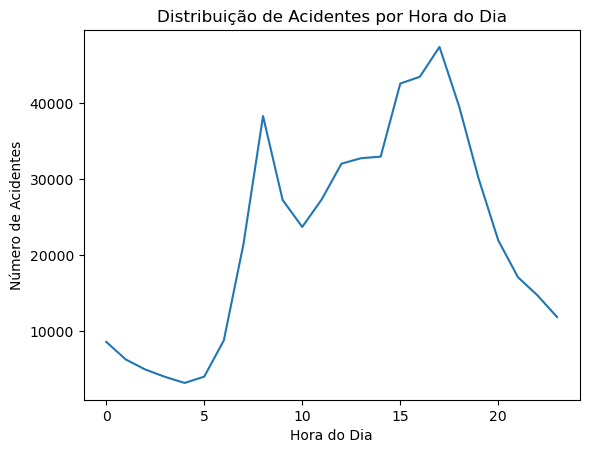

In [43]:
from pyspark.sql.functions import hour

# Criar coluna Hour a partir do timestamp na coluna Time
df_combinado = df_combinado.withColumn("Hour", hour("Time"))

df_hourly = df_combinado.groupBy("Hour").count().orderBy("Hour").toPandas()

import matplotlib.pyplot as plt

# Plotar distribuição de acidentes por hora
plt.plot(df_hourly["Hour"], df_hourly["count"])
plt.xlabel("Hora do Dia")
plt.ylabel("Número de Acidentes")
plt.title("Distribuição de Acidentes por Hora do Dia")
plt.show()


In [44]:
df_clima_acidentes = df_acidentes.groupBy("Weather_Conditions") \
    .count() \
    .orderBy(col("count").desc())

df_clima_acidentes.show()


+--------------------+-------+
|  Weather_Conditions|  count|
+--------------------+-------+
|Fine without high...|1203943|
|Raining without h...| 177663|
|               Other|  33503|
|             Unknown|  28422|
|Raining with high...|  20813|
|Fine with high winds|  18355|
|Snowing without h...|  11301|
|         Fog or mist|   8190|
|Snowing with high...|   1960|
+--------------------+-------+



In [45]:
df_trafego_anual = df_contagem.groupBy("Year") \
    .agg(_sum("cars_and_taxis").alias("Total_Cars_and_Taxis")) \
    .orderBy("Year")

df_trafego_anual.show()


+----+--------------------+
|Year|Total_Cars_and_Taxis|
+----+--------------------+
|2005|2.439972086240482...|
|2006|2.469057463337738...|
|2007|2.472724355087887E11|
|2008|2.454109091895252...|
|2009|2.447907502912415E11|
|2010|2.418658363616703E11|
|2011|2.443111378827205...|
|2012|2.454984019102785...|
|2013|2.466424670408943...|
|2014|2.535372554721770...|
+----+--------------------+



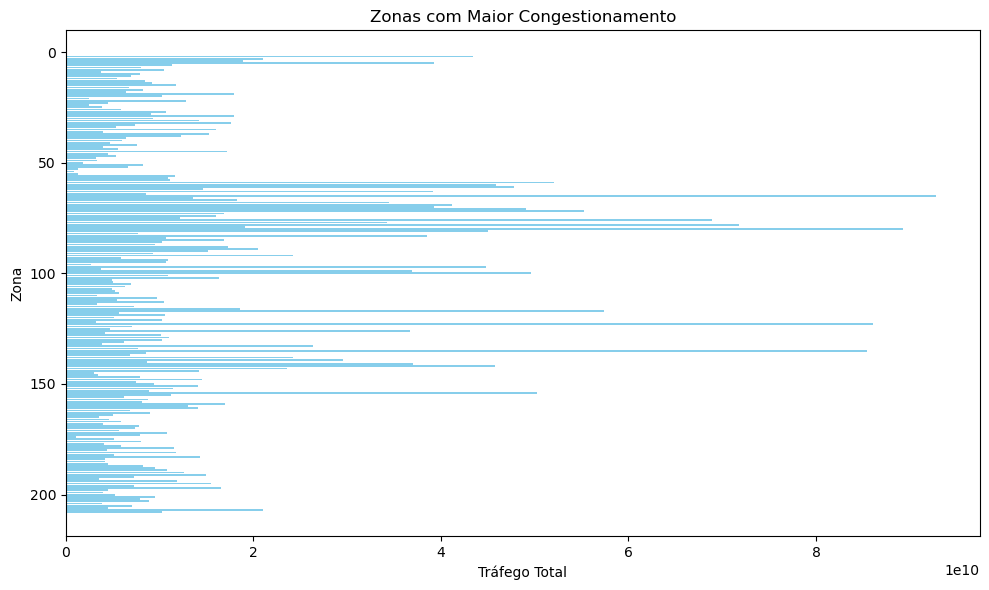

In [46]:
df_congestionamento_pd = df_congestionamento.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_congestionamento_pd["Authority_ID"], df_congestionamento_pd["Total_Traffic"], color="skyblue")
plt.xlabel("Tráfego Total")
plt.ylabel("Zona")
plt.title("Zonas com Maior Congestionamento")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


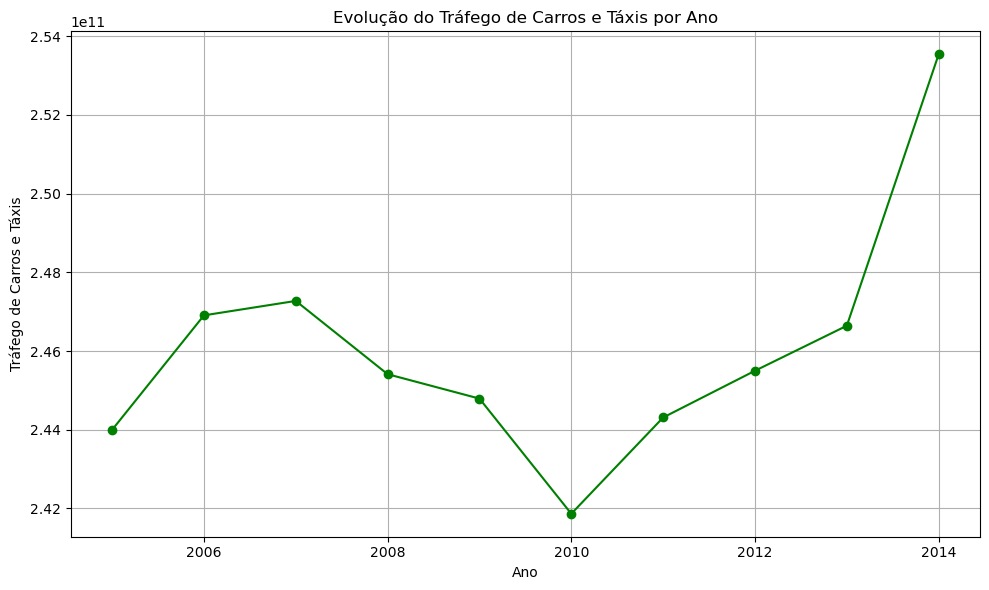

In [47]:
df_trafego_anual_pd = df_trafego_anual.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df_trafego_anual_pd["Year"], df_trafego_anual_pd["Total_Cars_and_Taxis"], marker="o", linestyle="-", color="green")
plt.xlabel("Ano")
plt.ylabel("Tráfego de Carros e Táxis")
plt.title("Evolução do Tráfego de Carros e Táxis por Ano")
plt.grid()
plt.tight_layout()
plt.show()


/tmp/ipykernel_7314/177094873.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_clima_acidentes_pd, x="Weather_Conditions", y="count",palette="Blues_d", ax=axs[1, 0])


Text(0, 0.5, 'Número de Veículos Envolvidos')

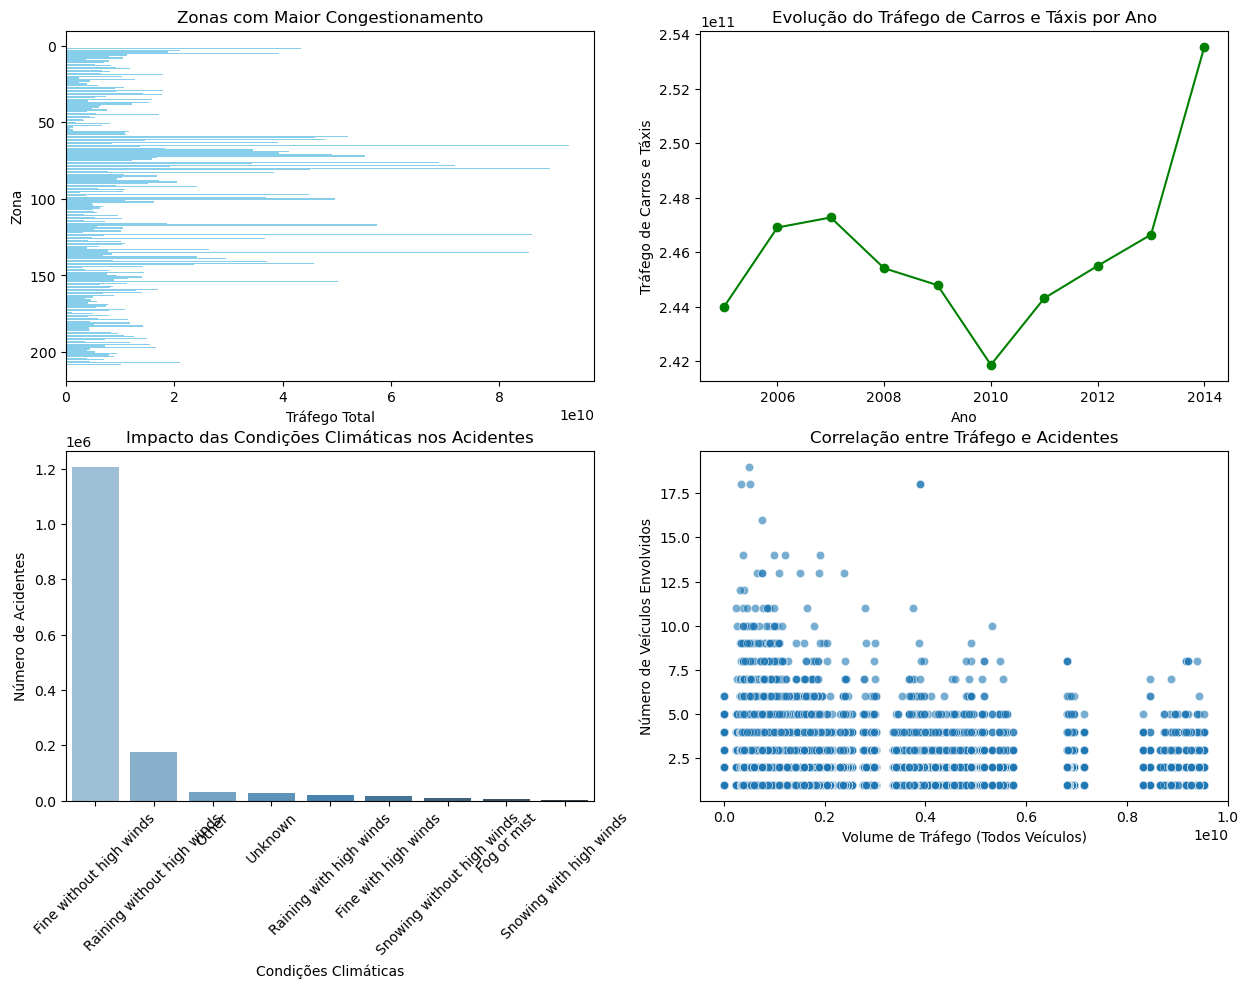

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Zonas com Maior Congestionamento
df_congestionamento_pd = df_congestionamento.toPandas()
axs[0, 0].barh(df_congestionamento_pd["Authority_ID"], df_congestionamento_pd["Total_Traffic"], color="skyblue")
axs[0, 0].set_title("Zonas com Maior Congestionamento")
axs[0, 0].set_xlabel("Tráfego Total")
axs[0, 0].set_ylabel("Zona")
axs[0, 0].invert_yaxis()

# Evolução do Tráfego de Carros e Táxis por Ano
df_trafego_anual_pd = df_trafego_anual.toPandas()
axs[0, 1].plot(df_trafego_anual_pd["Year"], df_trafego_anual_pd["Total_Cars_and_Taxis"], marker="o", linestyle="-", color="green")
axs[0, 1].set_title("Evolução do Tráfego de Carros e Táxis por Ano")
axs[0, 1].set_xlabel("Ano")
axs[0, 1].set_ylabel("Tráfego de Carros e Táxis")

# Condições Meteorológicas e Acidentes
df_clima_acidentes_pd = df_clima_acidentes.toPandas()

sns.barplot(data=df_clima_acidentes_pd, x="Weather_Conditions", y="count",palette="Blues_d", ax=axs[1, 0])
axs[1, 0].set_title("Impacto das Condições Climáticas nos Acidentes")
axs[1, 0].set_xlabel("Condições Climáticas")
axs[1, 0].set_ylabel("Número de Acidentes")
axs[1, 0].tick_params(axis="x", rotation=45)

# Correlação entre Tráfego e Acidentes
df_combinado_pd = df_combinado.toPandas()
sns.scatterplot(data=df_combinado_pd, x="all_motor_vehicles",y="Number_of_Vehicles", alpha=0.6, ax=axs[1, 1])
axs[1, 1].set_title("Correlação entre Tráfego e Acidentes")
axs[1, 1].set_xlabel("Volume de Tráfego (Todos Veículos)")
axs[1, 1].set_ylabel("Número de Veículos Envolvidos")



In [49]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Criar coluna de features com VectorAssembler
assembler = VectorAssembler(
    inputCols=["Speed_limit", "all_motor_vehicles", "Number_of_Casualties","Accident_Severity","Urban_or_Rural_Area"],
    outputCol="features"
)
df_model = assembler.transform(df_combinado).select("features", "Number_of_Vehicles")

# Renomear coluna alvo como label
df_model = df_model.withColumnRenamed("Number_of_Vehicles", "label")

# Divisão dos dados em treino e teste
train, test = df_model.randomSplit([0.8, 0.2], seed=42)

# Treinar o modelo GBT
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50)
gbt_model = gbt.fit(train)

# Fazer previsões
predictions_gbt = gbt_model.transform(test)

# Avaliar o modelo
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_gbt = evaluator.evaluate(predictions_gbt)
r2_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "r2"})

print(f"GBT RMSE: {rmse_gbt}")
print(f"GBT R²: {r2_gbt}")

# Visualizar previsões
predictions_gbt.select("features", "label", "prediction").show(10)

GBT RMSE: 0.6523004672894033
GBT R²: 0.10358266325546994
+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[20.0,2.412181676...|    2|1.6093452010691696|
|[20.0,2.551297992...|    2|1.6093452010691696|
|[20.0,3.125905012...|    2|1.6093452010691696|
|[20.0,3.251002989...|    2|1.9933147175448067|
|[20.0,3.278400191...|    2|1.9933147175448067|
|[20.0,3.307217096...|    1|1.6093452010691696|
|[20.0,3.362459824...|    1|1.6290343939572962|
|[20.0,3.785374315...|    2|  1.53365679836009|
|[20.0,4.146498089...|    1|1.5344959172406658|
|[20.0,4.215645005...|    2| 1.305136373664914|
+--------------------+-----+------------------+
only showing top 10 rows



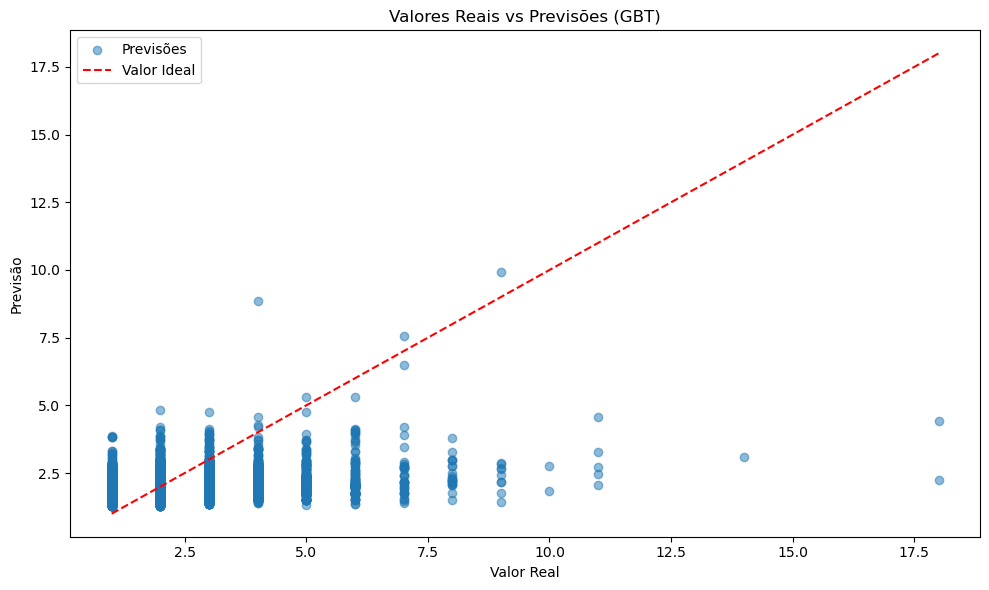

In [50]:
import matplotlib.pyplot as plt

# Converter para Pandas para visualização
predictions_pd = predictions_gbt.select("label", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["label"], predictions_pd["prediction"], alpha=0.5, label="Previsões")
plt.plot([predictions_pd["label"].min(), predictions_pd["label"].max()],
         [predictions_pd["label"].min(), predictions_pd["label"].max()], color="red", linestyle="--", label="Valor Ideal")
plt.xlabel("Valor Real")
plt.ylabel("Previsão")
plt.title("Valores Reais vs Previsões (GBT)")
plt.legend()
plt.tight_layout()
plt.show()


In [51]:
# Criar coluna de features com VectorAssembler
assembler = VectorAssembler(
    inputCols=["Year", "cars_and_taxis"],
    outputCol="features"
)
df_model = assembler.transform(df_combinado).select("features", "all_motor_vehicles")

# Renomear coluna alvo como label
df_model = df_model.withColumnRenamed("all_motor_vehicles", "label")

# Divisão dos dados em treino e teste
train, test = df_model.randomSplit([0.8, 0.2], seed=42)

# Treinar o modelo GBT
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50)
gbt_model = gbt.fit(train)

# Fazer previsões
predictions_gbt = gbt_model.transform(test)

# Avaliar o modelo
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_gbt = evaluator.evaluate(predictions_gbt)
r2_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "r2"})

print(f"GBT RMSE: {rmse_gbt}")
print(f"GBT R²: {r2_gbt}")

# Visualizar previsões
predictions_gbt.select("features", "label", "prediction").show(10)

GBT RMSE: 307466635.4041845
GBT R²: 0.9557647609735027
+--------------------+-----------+-------------------+
|            features|      label|         prediction|
+--------------------+-----------+-------------------+
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
|[2005.0,863484.9183]|1428899.884|9.192452372734429E7|
+--------------------+-----------+-------------------+
only showing top 10 rows



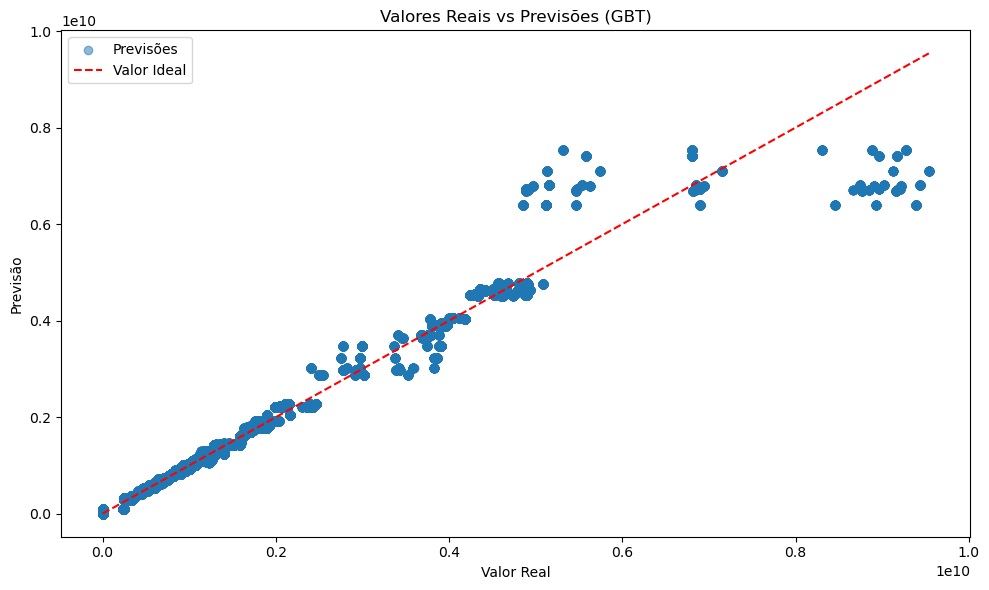

In [52]:
import matplotlib.pyplot as plt

# Converter para Pandas para visualização
predictions_pd = predictions_gbt.select("label", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["label"], predictions_pd["prediction"], alpha=0.5, label="Previsões")
plt.plot([predictions_pd["label"].min(), predictions_pd["label"].max()],
         [predictions_pd["label"].min(), predictions_pd["label"].max()], color="red", linestyle="--", label="Valor Ideal")
plt.xlabel("Valor Real")
plt.ylabel("Previsão")
plt.title("Valores Reais vs Previsões (GBT)")
plt.legend()
plt.tight_layout()
plt.show()
